In [ ]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import  lfilter
import pandas as pd

import pywt
import os
import glob

# --------- File loading and preprocessing ---------

# Path to filtered respiration data files and list of bad channels
filename = r"C:\Users\emir.ege-nemutlu\Desktop\resp\Clinical\interpcsv\interpSigCHU1077.csv"

# Load the filtered signal from CSV and transpose it


In [107]:

df = pd.read_csv(filename, sep=',')

def find_csv(base_path):
    # Look only in subfolders starting with CHU
    chu_dirs = glob.glob(os.path.join(base_path, "CHU*"))

    matches = []
    for d in chu_dirs:
        # Include only interpSig*.csv
        for p in glob.glob(os.path.join(d, "interpSig*.csv")):
            name = os.path.basename(p)
            # Exclude anything that looks like ECG*.csv just in case
            if not name.lower().startswith("ecg"):
                matches.append(p)

    return matches
base = r"C:\Users\emir.ege-nemutlu\Desktop\resp\Clinical"
paths = find_csv(base)


C:\Users\emir.ege-nemutlu\Desktop\resp\Clinical\CHU1013\interpSigCHU1013.csv
C:\Users\emir.ege-nemutlu\Desktop\resp\Clinical\CHU1020\interpSigCHU1020.csv
C:\Users\emir.ege-nemutlu\Desktop\resp\Clinical\CHU1027\interpSigCHU1027.csv
C:\Users\emir.ege-nemutlu\Desktop\resp\Clinical\CHU1056\interpSigCHU1056.csv
C:\Users\emir.ege-nemutlu\Desktop\resp\Clinical\CHU1058\interpSigCHU1058.csv
C:\Users\emir.ege-nemutlu\Desktop\resp\Clinical\CHU1062\interpSigCHU1062.csv
C:\Users\emir.ege-nemutlu\Desktop\resp\Clinical\CHU1069\interpSigCHU1069.csv
C:\Users\emir.ege-nemutlu\Desktop\resp\Clinical\CHU1077\interpSigCHU1077.csv
C:\Users\emir.ege-nemutlu\Desktop\resp\Clinical\CHU1088\interpSigCHU1088.csv
C:\Users\emir.ege-nemutlu\Desktop\resp\Clinical\CHU976\interpSigCHU976.csv
C:\Users\emir.ege-nemutlu\Desktop\resp\Clinical\CHU992\interpSigCHU992.csv


In [123]:

filename = paths[0]
base_folder = os.path.dirname(filename)  # Go up from Signals_Beats
save_dir = os.path.join(base_folder, "Signal_select_auto")
# os.makedirs(save_dir, exist_ok=True)
new_matfile_path = os.path.join(save_dir, (os.path.basename(filename).removesuffix(".csv")+'.mat'))
os.path.dirname(new_matfile_path)

'C:\\Users\\emir.ege-nemutlu\\Desktop\\resp\\Clinical\\CHU1013\\Signal_select_auto'

In [108]:

min_distance_qrs_ms = 300  # Minimum time between two QRS complexes (in ms)
sampling_rate = 1000.0     # Sampling rate in Hz
df.shape

(251, 51200)

In [91]:
start = int(0.4*1000)
end = int(200*1000)

Y = df.to_numpy(copy=True)
Y = Y[ :,start:end]
print(Y.shape)

time = np.linspace(0, df.shape[1] / 1000, df.shape[1])
time = time[start:end]
print(time.shape)

# Step 1: Apply FIR filter to each row using lfilter
# lfilter does not natively broadcast over axis 0, so we use list comprehension or a matrix operation
h = [0.1, 0.2, 0.0, -0.2, -0.1]
H = np.array(h)
Y_filtered = np.apply_along_axis(lambda row: lfilter(H, 1.0, row), axis=1, arr=Y)

thresholdpercent = 0.2

windowsize = int(0.150*2000)
# Step 2: Square the filtered signal
Y_squared = Y_filtered ** 2
# Step 3: Moving average (via convolution), applied row-wise
kernel = np.ones(windowsize) / windowsize
Y_smoothed = np.apply_along_axis(lambda row: np.convolve(row, kernel, mode='same'), axis=1, arr=Y_squared)
mean_smoothed = np.mean(Y_smoothed, axis=0)  # Shape: (n_samples,)

thresholds = np.max(Y_smoothed, axis=1, keepdims=True) * thresholdpercent
pwm_signals = (Y_smoothed > thresholds).astype(int)

pwm_signal = (mean_smoothed > np.max(mean_smoothed)*thresholdpercent)

(251, 50800)
(50800,)


In [92]:
totalPWM= np.apply_along_axis(lambda coulmn: np.sum(coulmn) > 4,axis=0 ,arr=pwm_signals ).astype(int)


In [101]:
gradpwm = np.gradient(totalPWM)
qrsOnset = np.where((gradpwm>0)==True)[0]
qrsEndset = np.where((gradpwm<0)==True)[0]

min_gap = 20  

# Keep only the indices that are far enough apart from the previous one
qrsOnset = qrsOnset[np.insert(np.diff(qrsOnset) > min_gap, 0, True)]
qrsEndset = qrsEndset[np.insert(np.diff(qrsEndset) > min_gap, 0, True)]


if qrsOnset[0] > qrsEndset[0]:  
    qrsEndset = qrsEndset[1:]  # Remove first high peak if it occurs before the first trough
    print("first high_peaks removed")
# Ensure the signal ends with a high peak
if qrsOnset[-1] > qrsEndset[-1]:
    print("last low_peaks removed")
    qrsOnset = qrsOnset[:-1]  # Remove last low peak if it occurs after the last high peak


qrsRange = np.mean(qrsEndset-qrsOnset)
beatRange = np.mean(qrsEndset[1:]-qrsOnset[:-1])

first high_peaks removed
last low_peaks removed


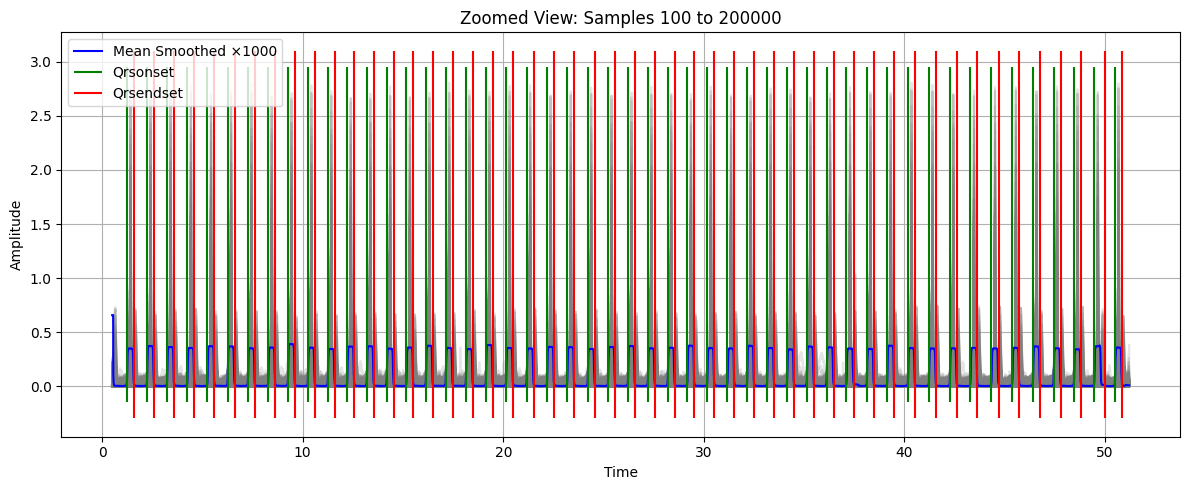

In [102]:


plotstart = int(0.1*1000)
plotstop = int(200*1000)



plt.figure(figsize=(12, 5))

# Plot all original signals (absolute value) in gray
for i in range(Y.shape[0]):
    plt.plot(time[plotstart:plotstop], np.abs(Y[i, plotstart:plotstop]), alpha=0.2, color='gray')

# Plot mean smoothed
plt.plot(time[plotstart:plotstop], (mean_smoothed[plotstart:plotstop]*(Y.max())/(mean_smoothed[plotstart:plotstop].max()*2)) , label='Mean Smoothed ×1000', color='blue')

# Plot PWM signal
plt.vlines(time[qrsOnset],ymin=plt.ylim()[0], ymax=plt.ylim()[1], label='Qrsonset', color='green')

# Plot gradient of PWM
plt.vlines(time[qrsEndset],ymin=plt.ylim()[0], ymax=plt.ylim()[1],  label='Qrsendset', color='red')

plt.title(f"Zoomed View: Samples {plotstart} to {plotstop}")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend(loc=2)
plt.tight_layout()
plt.show()


In [103]:

print(len(qrsOnset[:-1]))
print(len(qrsEndset[1:]))
print(np.mean(qrsEndset[1:]-qrsOnset[:-1]))

49
49
1358.5102040816328


In [16]:
y = Y[50][:]
# time = your time axis (same length as y)
print(y.shape)
# Use Haar wavelet with 5-level decomposition
wavelet = 'db1'
coeffs = pywt.wavedec(y, wavelet=wavelet, level=4)

# Reconstruct and align each component to original length
aligned_components = []
labels = []

for i in range(len(coeffs)):
    # Zero out all other levels
    zeroed_coeffs = [np.zeros_like(c) for c in coeffs]
    zeroed_coeffs[i] = coeffs[i]
    
    # Reconstruct only this component
    component = pywt.waverec(zeroed_coeffs, wavelet=wavelet)
    
    # Pad if reconstruction is shorter than original
    if len(component) < len(y):
        component = np.pad(component, (0, len(y) - len(component)), mode='edge')
    
    aligned_components.append(component)
    
    # Label: first is approximation, rest are detail levels
    if i == 0:
        labels.append(f'Approximation (Level {len(coeffs) - 1})')
    else:
        labels.append(f'Detail (Level {len(coeffs) - i})')


(50800,)


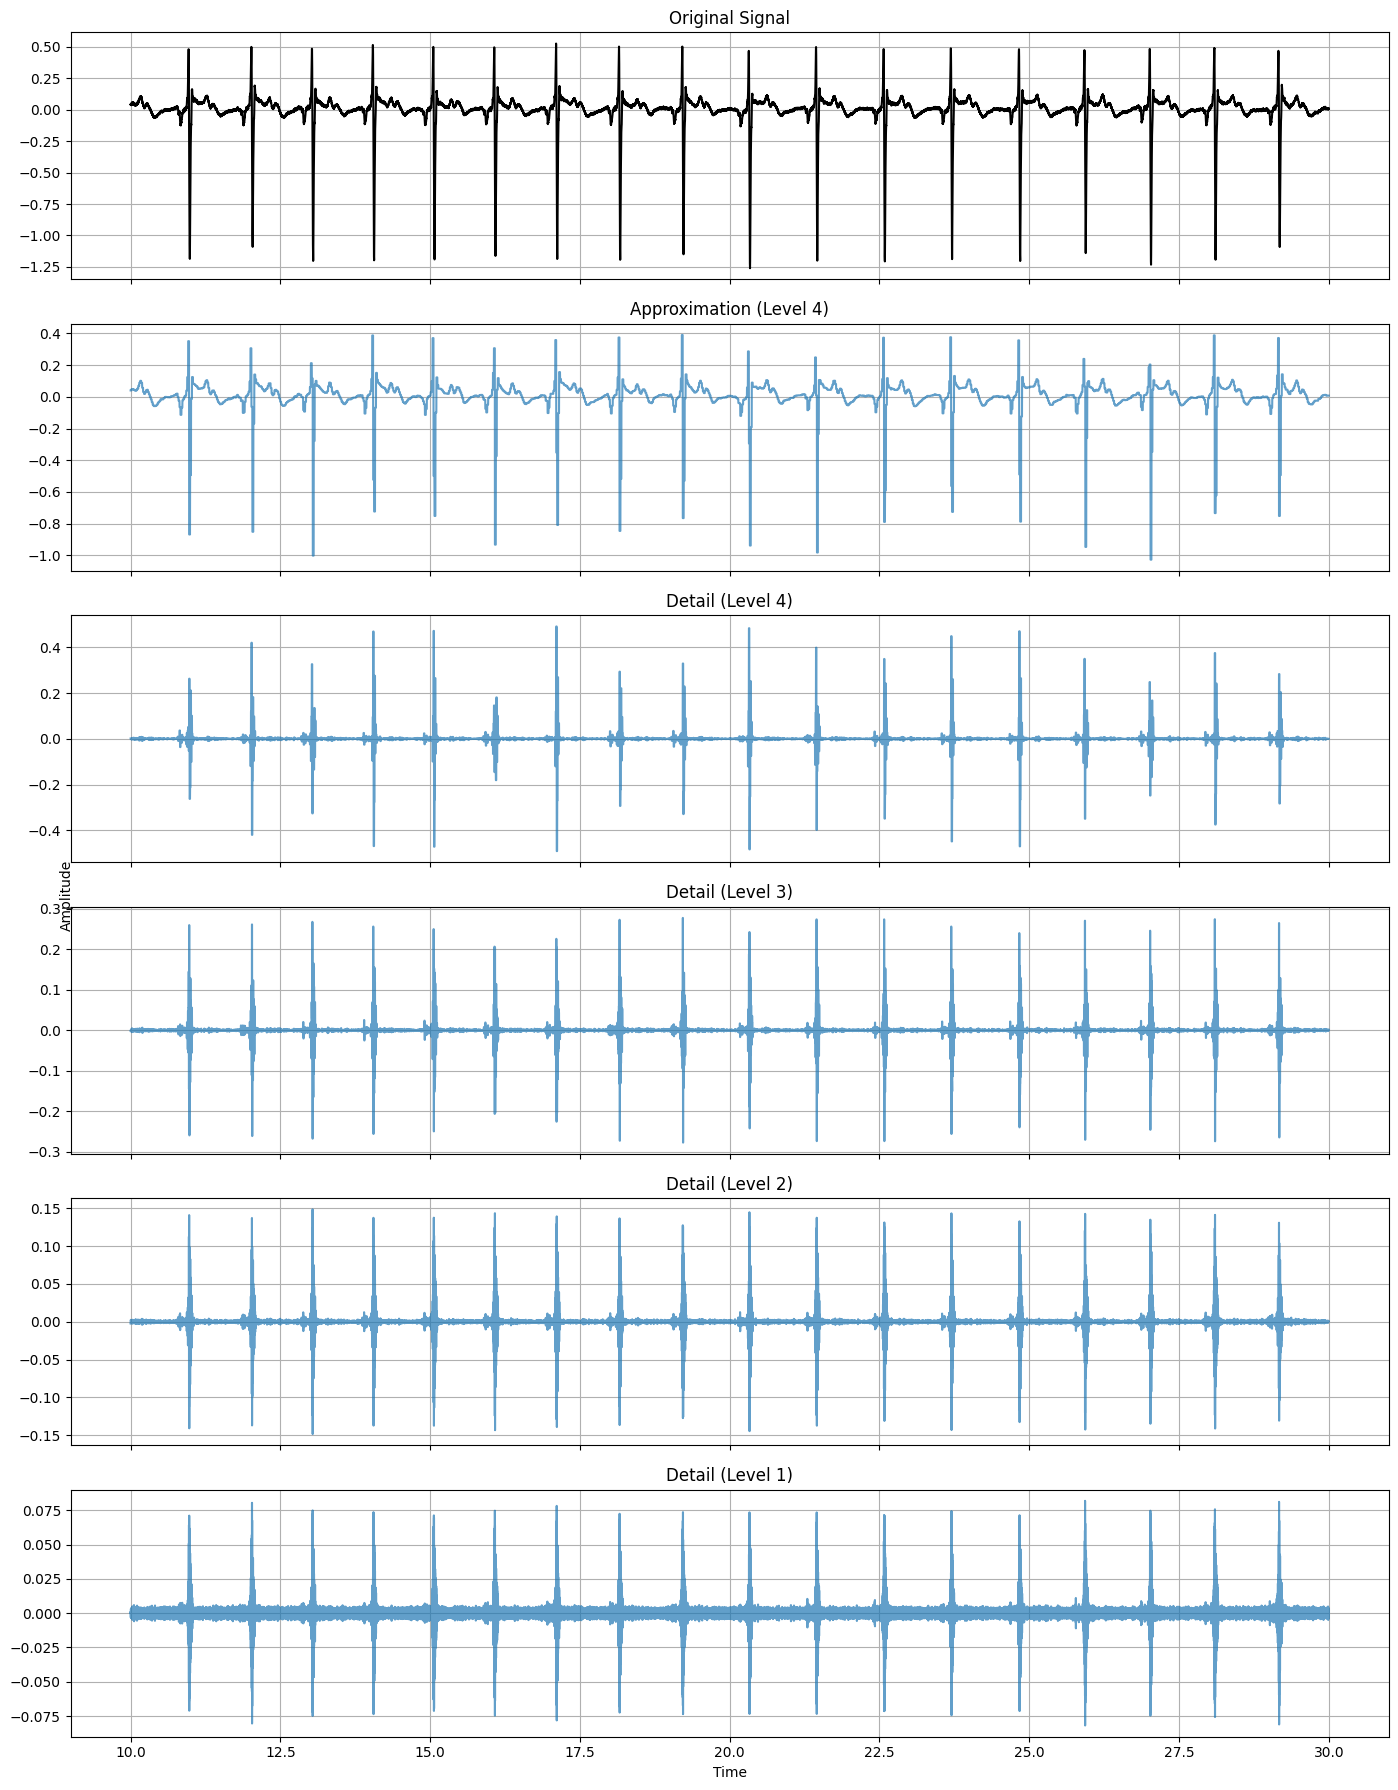

In [31]:
n_plots = 1 + len(aligned_components)  # original + each component
fig, axes = plt.subplots(n_plots, 1, figsize=(14, 3*n_plots), sharex=True)

# 1) Original signal on the first row
axes[0].plot(time, y, color='black', linewidth=1.5)
axes[0].set_title("Original Signal")
axes[0].grid(True)

# 2) Each wavelet component on its own row
for ax, comp, label in zip(axes[1:], aligned_components, labels):
    ax.plot(time, comp, alpha=0.7)
    ax.set_title(label)
    ax.grid(True)

# 3) Common X/Y labels only at the bottom / left
axes[-1].set_xlabel("Time")
fig.text(0.04, 0.5, "Amplitude", va='center', rotation='vertical')

plt.tight_layout()
plt.show()